In [4]:
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [2]:
# Initialize the optimization model
model = gp.Model("MacPhersonRefrigeration")

# Define the time periods for the planning horizon
months = range(1, 13)  # 1 for January, 2 for February, etc.

# Parameters for costs
monthly_cost_per_worker = 2400
hiring_cost_per_worker = 1800
layoff_cost_per_worker = 1200
holding_cost_per_unit_per_month = 8

# Parameters for workforce calculations
initial_workers = 160  # Starting number of workers
standard_hours_per_month = 160  # 40 hours/week * 4 weeks
hours_needed_per_unit = 4  # Hours needed to produce one unit
max_overtime_hours_per_worker = standard_hours_per_month * 0.5  # 50% of standard hours
additional_units_per_overtime_hour = 0.25  # Units produced per overtime hour
cost_per_overtime_hour = (monthly_cost_per_worker / standard_hours_per_month) * 1.5

# Initial inventory parameter
initial_inventory = 240  # Set the initial inventory level

# Forecasted demand for each month
shipment_forecast = [4400, 4400, 6000, 8000, 6600, 11800, 13000, 11200, 10800, 7600, 6000, 5600]

# Decision variables
production = model.addVars(months, name="Production", lb=0, vtype=GRB.INTEGER)
inventory = model.addVars(months, name="Inventory", lb=0, vtype=GRB.INTEGER, obj=holding_cost_per_unit_per_month)
workers = model.addVars(months, name="Workers", lb=0, vtype=GRB.INTEGER)
hiring = model.addVars(months, name="Hiring", lb=0, vtype=GRB.INTEGER)
layoffs = model.addVars(months, name="Layoffs", lb=0, vtype=GRB.INTEGER)
overtime = model.addVars(months, name="Overtime", lb=0)

# Constraints

# Workforce initialization
model.addConstr(workers[1] == initial_workers, "InitialNumberOfWorkers")

# Workforce dynamics
workforce_dynamics = model.addConstrs(
    (workers[m] == workers[m-1] + hiring[m] - layoffs[m] for m in range(2, 13)),
    "WorkforceDynamics")

# Staffing level changes
staffing_level_changes = model.addConstrs(
    (workers[m] * standard_hours_per_month + additional_units_per_overtime_hour * overtime[m] == hours_needed_per_unit * production[m] for m in months),
    "StaffingLevelChanges")

# Demand satisfaction for the first month, including initial inventory and potential overtime production
model.addConstr(
    (production[1] + additional_units_per_overtime_hour * overtime[1] + initial_inventory - inventory[1] >= shipment_forecast[0]),
    "FirstMonthDemandConstraint")

# Demand satisfaction for the subsequent months
demand_constraints = model.addConstrs(
    (production[m] + additional_units_per_overtime_hour * overtime[m] + 
     inventory[m-1] - inventory[m] >= shipment_forecast[m-1] for m in range(2, 13)), 
    "DemandConstraints")

# Inventory at the end of the first month
model.addConstr(
    (inventory[1] == initial_inventory + production[1] - shipment_forecast[0]),
    "FirstMonthInventoryDynamics")

# Inventory dynamics for subsequent months
inventory_dynamics = model.addConstrs(
    (inventory[m] == inventory[m-1] + production[m] - shipment_forecast[m-1] for m in range(2, 13)), 
    "InventoryDynamics")

# Overtime constraints
overtime_constraints = model.addConstrs(
    (overtime[m] * additional_units_per_overtime_hour <= max_overtime_hours_per_worker for m in months),
    "OvertimeLimits")

# Objective function to minimize total costs, including initial inventory holding cost
model.setObjective(
    holding_cost_per_unit_per_month * initial_inventory +  # Initial inventory holding cost
    gp.quicksum(monthly_cost_per_worker * workers[m] for m in months) +  # Monthly cost for all workers
    gp.quicksum(hiring_cost_per_worker * hiring[m] for m in months) +  # Cost for hiring
    gp.quicksum(layoff_cost_per_worker * layoffs[m] for m in months) +  # Cost for layoffs
    gp.quicksum(cost_per_overtime_hour * overtime[m] for m in months) +  # Cost for overtime
    gp.quicksum(holding_cost_per_unit_per_month * inventory[m] for m in months),  # Cost for holding inventory
    gp.GRB.MINIMIZE)

# Optimize the model
model.setParam('OutputFlag', 1)
model.optimize()

# Retrieve the optimal objective value
optimal_objective_value = model.ObjVal

# Print the optimal objective value in standard dollar format
print("\nOptimal Objective (Total Cost): ${:,.2f}\n".format(optimal_objective_value))

# Print column headers
print("{:<10} {:<15} {:<15} {:<15} {:<10} {:<10} {:<10} {:<10}".format(
    'Month', 'Shipment Forecast', 'Total Workers', 'Production', 'Inventory', 'Hiring', 'Layoffs', 'Overtime'))

# Output the solution
for m in months:
    # Include initial inventory for the first month
    if m == 1:
        print("\nInitial Inventory: {:,}\n".format(initial_inventory))
    
    # Print the data for the current month in a formatted way
    print("{:<10} {:<15} {:<15,.2f} {:<15,.2f} {:<15,.2f} {:<10,.2f} {:<10,.2f} {:<10,.2f}".format(
        m, shipment_forecast[m-1], workers[m].X, production[m].X, 
        inventory[m].X, hiring[m].X, layoffs[m].X, overtime[m].X))

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2432950
Academic license - for non-commercial use only - registered to samuelswain2023@u.northwestern.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10850K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license - for non-commercial use only - registered to samuelswain2023@u.northwestern.edu
Optimize a model with 60 rows, 72 columns and 175 nonzeros
Model fingerprint: 0x120afc84
Variable types: 12 continuous, 60 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e+00, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 1e+04]
Found heuristic solution: objective 1.112708e+07
Presolve removed 38 rows and 28 columns
Presolve time: 0.00s
Presolved: 22 rows, 44 columns, 75 nonzeros
Found heuristic solution: objecti

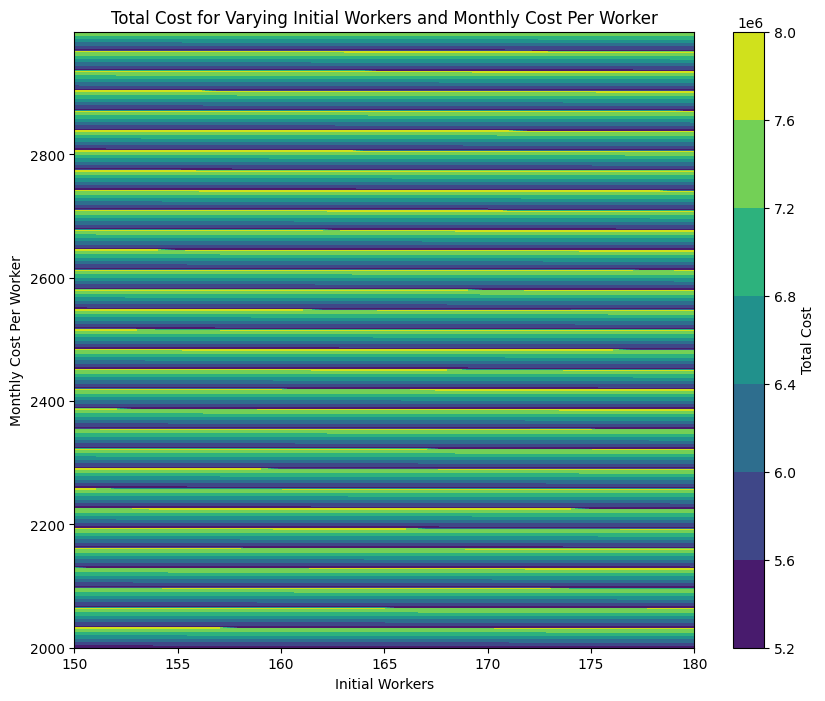

In [15]:
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Define the time periods for the planning horizon
months = range(1, 13)  # 1 for January, 2 for February, etc.

# Fixed parameters
hiring_cost_per_worker = 1800
layoff_cost_per_worker = 1200
holding_cost_per_unit_per_month = 8
standard_hours_per_month = 160  # 40 hours/week * 4 weeks
hours_needed_per_unit = 4  # Hours needed to produce one unit
max_overtime_hours_per_worker = standard_hours_per_month * 0.5  # 50% of standard hours
additional_units_per_overtime_hour = 0.25  # Units produced per overtime hour
initial_inventory = 240  # Set the initial inventory level
shipment_forecast = [4400, 4400, 6000, 8000, 6600, 11800, 13000, 11200, 10800, 7600, 6000, 5600]

# Define ranges for varying parameters
initial_workers_range = range(150, 181)  # Example range for initial workers
monthly_cost_per_worker_range = range(2000, 3000, 1)  # Example range for monthly cost per worker

# Initialize a list to store results
results = []

# Loop over the ranges of parameters
for initial_workers in initial_workers_range:
    for monthly_cost_per_worker in monthly_cost_per_worker_range:
        # Initialize the optimization model
        model = gp.Model("MacPhersonRefrigeration")

        # Suppress Gurobi output
        model.setParam('OutputFlag', 0)

        # Update cost per overtime hour based on varying monthly_cost_per_worker
        cost_per_overtime_hour = (monthly_cost_per_worker / standard_hours_per_month) * 1.5

        # Decision variables
        production = model.addVars(months, name="Production", lb=0, vtype=GRB.INTEGER)
        inventory = model.addVars(months, name="Inventory", lb=0, vtype=GRB.INTEGER, obj=holding_cost_per_unit_per_month)
        workers = model.addVars(months, name="Workers", lb=0, vtype=GRB.INTEGER)
        hiring = model.addVars(months, name="Hiring", lb=0, vtype=GRB.INTEGER)
        layoffs = model.addVars(months, name="Layoffs", lb=0, vtype=GRB.INTEGER)
        overtime = model.addVars(months, name="Overtime", lb=0)

        # Constraints

        # Workforce initialization
        model.addConstr(workers[1] == initial_workers, "InitialNumberOfWorkers")

        # Workforce dynamics
        workforce_dynamics = model.addConstrs(
            (workers[m] == workers[m-1] + hiring[m] - layoffs[m] for m in range(2, 13)),
            "WorkforceDynamics")

        # Staffing level changes
        staffing_level_changes = model.addConstrs(
            (workers[m] * standard_hours_per_month + additional_units_per_overtime_hour * overtime[m] == hours_needed_per_unit * production[m] for m in months),
            "StaffingLevelChanges")

        # Demand satisfaction for the first month, including initial inventory and potential overtime production
        model.addConstr(
            (production[1] + additional_units_per_overtime_hour * overtime[1] + initial_inventory - inventory[1] >= shipment_forecast[0]),
            "FirstMonthDemandConstraint")

        # Demand satisfaction for the subsequent months
        demand_constraints = model.addConstrs(
            (production[m] + additional_units_per_overtime_hour * overtime[m] + 
            inventory[m-1] - inventory[m] >= shipment_forecast[m-1] for m in range(2, 13)), 
            "DemandConstraints")

        # Inventory at the end of the first month
        model.addConstr(
            (inventory[1] == initial_inventory + production[1] - shipment_forecast[0]),
            "FirstMonthInventoryDynamics")

        # Inventory dynamics for subsequent months
        inventory_dynamics = model.addConstrs(
            (inventory[m] == inventory[m-1] + production[m] - shipment_forecast[m-1] for m in range(2, 13)), 
            "InventoryDynamics")

        # Overtime constraints
        overtime_constraints = model.addConstrs(
            (overtime[m] * additional_units_per_overtime_hour <= max_overtime_hours_per_worker for m in months),
            "OvertimeLimits")

        # Objective function to minimize total costs, including initial inventory holding cost
        model.setObjective(
            holding_cost_per_unit_per_month * initial_inventory +  # Initial inventory holding cost
            gp.quicksum(monthly_cost_per_worker * workers[m] for m in months) +  # Monthly cost for all workers
            gp.quicksum(hiring_cost_per_worker * hiring[m] for m in months) +  # Cost for hiring
            gp.quicksum(layoff_cost_per_worker * layoffs[m] for m in months) +  # Cost for layoffs
            gp.quicksum(cost_per_overtime_hour * overtime[m] for m in months) +  # Cost for overtime
            gp.quicksum(holding_cost_per_unit_per_month * inventory[m] for m in months),  # Cost for holding inventory
            gp.GRB.MINIMIZE)

        # Optimize the model
        model.optimize()

        # Collect the results
        total_cost = model.ObjVal
        results.append((initial_workers, monthly_cost_per_worker, total_cost))

# Convert results to a NumPy array for easy manipulation
results_array = np.array(results)

# Unique values for initial_workers and monthly_cost_per_worker
unique_workers = np.unique(results_array[:,0])
unique_costs = np.unique(results_array[:,1])

# Reshape results for plotting
x, y = np.meshgrid(unique_workers, unique_costs)
z = results_array[:,2].reshape(len(unique_costs), len(unique_workers))

# Create a heatmap of total cost
plt.figure(figsize=(10, 8))
plt.contourf(x, y, z, cmap='viridis')
plt.colorbar(label='Total Cost')
plt.xlabel('Initial Workers')
plt.ylabel('Monthly Cost Per Worker')
plt.title('Total Cost for Varying Initial Workers and Monthly Cost Per Worker')
plt.show()
